# Machine Learning Models

Continuation of notes about SciPy2019 talk by Aileen Nielsen.

[Original notebook](https://github.com/PracticalTimeSeriesAnalysis/BookRepo/blob/master/Ch09/Classification.ipynb) contains much more code than I chose to play with here.

## Time series feature generation

There are no (none at all?) machine learning algorithms that have been specifically developed for handling time series models. Indeed, many ml algorithms do not support the notion of temporal data. Therefore, it is necessary to make your time series data fit into a representation that the ml algorithm in question does support. For example, Decision Trees are not built to handle temporal data.

You can handle this mismatch by generating suitable features from your time series data. For example, record the minimum and maximum values (and time stamps?), count the number of peaks and valleys in time windows, compute the mean and median over such windows.

If you have many time series that span long periods of time and compute such features once every minute (or whatever the time step in your data is), then this can become computationally expensive.

There are canonical feature sets that have been developed for time series. According to Aileen, if you have a specific use case / domain, you should be able to do better than a canonical feature set using domain knowledge and analyzing your data. Time series features are discipline-specific. 

This may be true, but still wondering what to do when faced with very large multivariate time series datas sets. 

You can either chop up a time series signal into windows and treat each window as a sample. This is what you would typically do in the univariate case. Or you can treat each time series signal as its own sample. These two options exist for both the univariate and the multivariate case.

It is probabably important to remove / smooth out seasonal and trend components to be able to focus on the underlying process itself.

A few of the models being discussed:
* Random Forests using xgboost. You learn your first decision tree and then learn the second one based on the errors of the first one. In practice, xgboost is said to perform well with time series classification.
* Clustering. Difficult both conceptually and due to computational costs. Need to be careful to pick a good distance metric (e.g., not Euclidean distance). Need to be careful that you really cluster time series with similar features. Put differently, you need to find features that distinguish well between different time series (domain knowledge?).
  * Clustering can be based on features that you identify in time series (e.g., either by looking for the features from a canonical set or with custom-code to look for relevant features in your domain). This can become computationally expensive. Think thousands of time series each with tens of thousands of data points you need to analyze.
  * Clustering can also be done using a suitable distance metric. The one recommended for time series data is [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).


## Classification using trees

I could not get the `featurize` import from `cesium` to work. Instead, I have made use of a ready-made file of features. Just know that there are several packages out there to help with time series feature extraction in Matlab, R, and Python. The features are based on a configuration in the form of a list of feature names passed to `cesium` (configuration is not shown here).

In [3]:
import matplotlib.pyplot as plt
import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
#from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [10, 10]

There are packages that can extract features from time series. `cesium` is one such package. More [details](https://github.com/cesium-ml/cesium), including the list of features, such as number of peaks, index of $i^{th}$ largest peak, total number of observed values, difference between maximum and minimum time values, mean of time values, amplitude, skewness and many more. Apparently, there are more than 7,700 time series features :dizzy_face:

In [25]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [26]:
type(eeg)

dict

In [27]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [28]:
print(f'Type of measurements: {type(eeg["measurements"][0])}')
print(f'Len: {len(eeg["measurements"])})')
print(f'Dimensions: {eeg["measurements"][0].shape}')
eeg["measurements"][0:50:10]

Type of measurements: <class 'numpy.ndarray'>
Len: 500)
Dimensions: (4097,)


[array([ 40.,  48.,  35., ..., -34., -27., -42.]),
 array([ 14.,  25.,  31., ..., -26., -28.,  21.]),
 array([-58., -59., -60., ..., -43., -59.,  23.]),
 array([-21., -29., -34., ...,  18.,   6.,  25.]),
 array([ -45., -105., -106., ...,   22.,    5.,   96.])]

500 rows with 4,097 elements or samples per row (if I read this correctly).

In [29]:
print(f'Type of classes: {type(eeg["classes"][0])}')
print(f'Len: {len(eeg["classes"])})')
print(f'Dimensions: {eeg["classes"].shape}')
eeg["classes"]

Type of classes: <class 'numpy.str_'>
Len: 500)
Dimensions: (500,)


array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [30]:
print(f'Type of times: {type(eeg["times"][0])}')
print(f'Len: {len(eeg["times"])})')
eeg["times"][0:50]

Type of times: <class 'numpy.ndarray'>
Len: 500)


[array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.15234375e-02, ...,
        2.35884766e+01, 2.35942383e+01, 2.36000000e+01]),
 array([0.00000000e+00, 5.76171875e-03, 1.152343

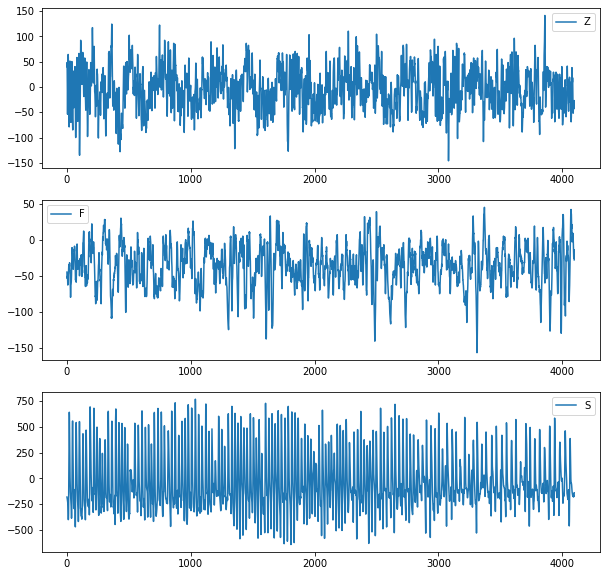

In [31]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [32]:
# loading prepared features
fset_cesium = pd.read_csv("data/full_eeg_data_features.csv", header = [0, 1])

In [33]:
! head -n 3 data/full_eeg_data_features.csv

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.3273126678057115,0.5050036612155235,0.03280499636078603,11107.796610166752


In [34]:
fset_cesium.head(10)

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153
5,5,151.5,0.308763,0.524774,0.002501,10934.237288
6,6,162.0,0.308518,0.531853,0.003179,12843.389831
7,7,126.5,0.324628,0.565780,-0.023597,8851.525424
8,8,105.0,0.324140,0.491091,-0.002426,7463.050847


In [35]:
fset_cesium.shape

(500, 6)

By picking a handful of features, we have managed to digest $500 \times 4,097$ down to $500 \times 5$. Of course, this does not explain the art of magic of how to pick a set of features that matches your data and problem.

In [36]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


(array([311.,  85.,  30.,  19.,   8.,  13.,   7.,  14.,   7.,   6.]),
 array([  63. ,  241.5,  420. ,  598.5,  777. ,  955.5, 1134. , 1312.5,
        1491. , 1669.5, 1848. ]),
 <a list of 10 Patch objects>)

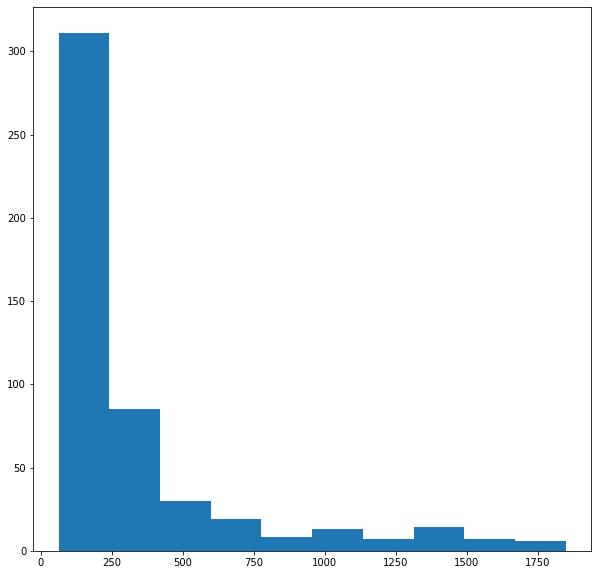

In [37]:
# select all rows, second column (which I think is amplitude) and plot as a histogram
plt.hist(fset_cesium.iloc[:, 1])

In [38]:
fset_cesium['classes'] = eeg['classes']
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

In [39]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope,classes
0,0,143.5,0.327313,0.505004,0.032805,11107.796610,Z
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322,Z
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119,Z
3,3,171.5,0.300952,0.541128,0.063678,17008.813559,Z
4,4,170.0,0.305101,0.566268,0.142753,13016.949153,Z


classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: amplitude, dtype: object

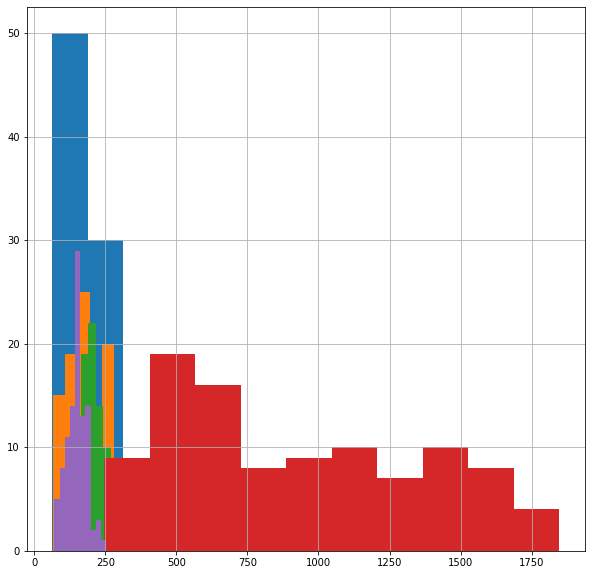

In [40]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28d67050>,
      dtype=object)

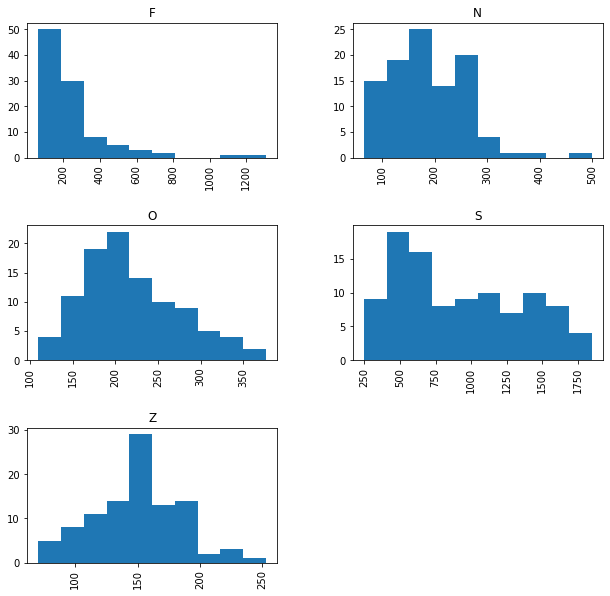

In [41]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25582a10>,
      dtype=object)

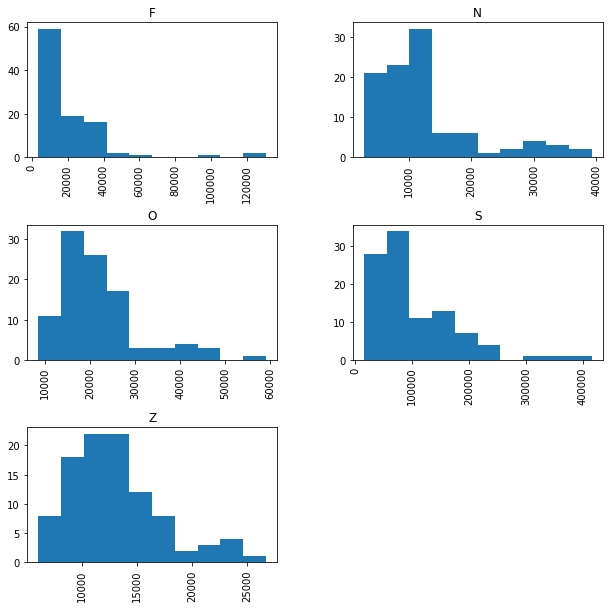

In [42]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

classes
F    AxesSubplot(0.125,0.125;0.775x0.755)
N    AxesSubplot(0.125,0.125;0.775x0.755)
O    AxesSubplot(0.125,0.125;0.775x0.755)
S    AxesSubplot(0.125,0.125;0.775x0.755)
Z    AxesSubplot(0.125,0.125;0.775x0.755)
Name: max_slope, dtype: object

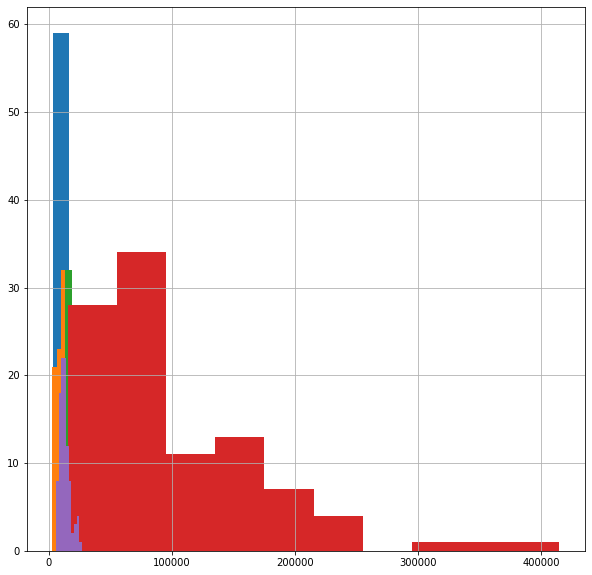

In [43]:
fset_cesium.groupby('classes')['max_slope'].hist()

### Train and evaluate a Random Forest

Want to train a Random Forest using some parameter-settings (just playing here) and then evaluate its accuracy by comparing it against a random model and by computing its F-1 score.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.iloc[:, 1:6].values, eeg["classes"], random_state=21)

In [45]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=21)

In [46]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [47]:
clf_rf.score(X_train, y_train)

0.6266666666666667

In [48]:
clf_rf.score(X_test, y_test)

0.616

In [49]:
y_pred = clf_rf.predict(X_test)

In [50]:
from sklearn import metrics

In [51]:
print(f"RF Accuracy: {metrics.accuracy_score(y_test, y_pred)}")

RF Accuracy: 0.616


I am using a weighted approach to compute precision in a multi-class setting. A very readable introduction into how to evaluate the performance of classifiers for multi-class problems can be found in a two-part blog post titled Multi-Class Metrics Made Simple [part 1](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) and [part 2](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1).

In [52]:
print(f"RF Precision: {metrics.precision_score(y_test, y_pred, average='weighted')}")

RF Precision: 0.60517068364081


In [53]:
print(f"RF Recall: {metrics.recall_score(y_test, y_pred, average='weighted')}")

RF Recall: 0.616


In [54]:
print(f"RF F-1 score: {metrics.f1_score(y_test, y_pred, average='weighted')}")

RF F-1 score: 0.5968477692080176


In [55]:
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           F      0.333     0.200     0.250        20
           N      0.550     0.379     0.449        29
           O      0.581     0.857     0.692        21
           S      0.957     0.880     0.917        25
           Z      0.564     0.733     0.638        30

    accuracy                          0.616       125
   macro avg      0.597     0.610     0.589       125
weighted avg      0.605     0.616     0.597       125



### Train and evaluate XGBoost

In [59]:
clf_xgb = xgb.XGBClassifier(n_estimators=10, max_depth=3, random_state=21)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
clf_xgb.score(X_test, y_test)

0.688

In [61]:
clf_xgb.score(X_train, y_train)

0.7866666666666666

In [62]:
y_pred = clf_xgb.predict(X_test)

In [63]:
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           F      0.429     0.300     0.353        20
           N      0.655     0.655     0.655        29
           O      0.581     0.857     0.692        21
           S      0.958     0.920     0.939        25
           Z      0.741     0.667     0.702        30

    accuracy                          0.688       125
   macro avg      0.673     0.680     0.668       125
weighted avg      0.688     0.688     0.681       125



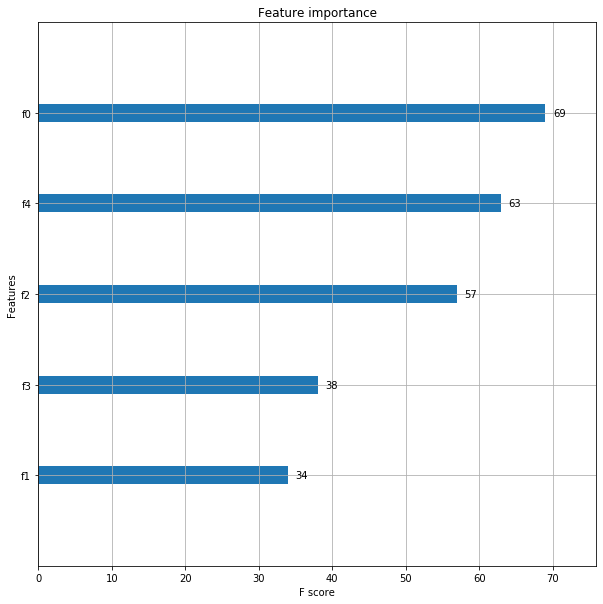

In [64]:
xgb.plot_importance(clf_xgb)

Finds that `amplitude` followed by `1 % beyond std` seem to be useful to this classifier. Next exercise would be to run through different feature sets to determine others that can be more useful than current set.

### Time series forecasting with decision trees

You may want to remove / smooth out seasonal and trend components as most machine learning models do not take the temporal aspects into account. Removing these components reduces the variance and makes the time series values at different points in time or during different windows more comparable with each other.

In [108]:
ap = pd.read_csv("../pycon2017/data/AirPassengers.csv")

In [109]:
ap.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [110]:
ap.set_index("Month", inplace=True)

In [111]:
ap.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


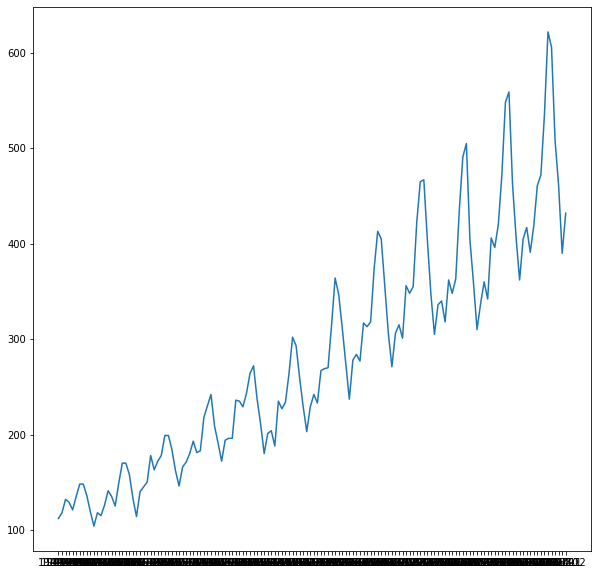

In [112]:
plt.plot(ap)

We see evidence of trend and seasonal components. We make the time series data points more comparable to each other by computing the differences of the logs of their values.

In [113]:
ts = np.diff(np.log(ap.values[:, 0]))

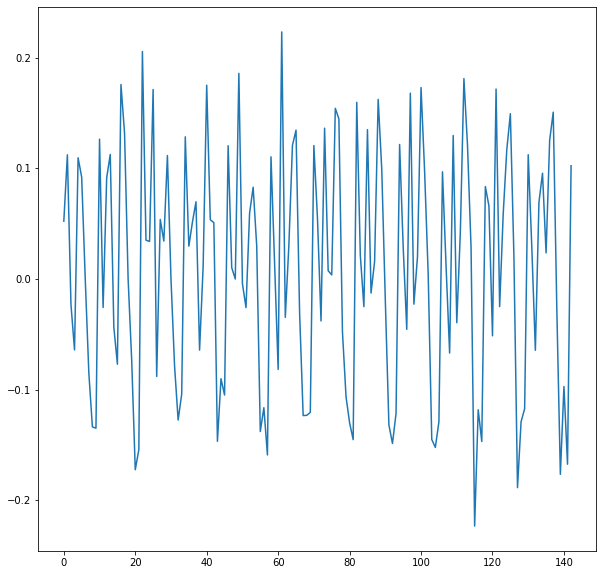

In [114]:
plt.plot(ts)

This looks much more uniform, easier to compare. Next, we need to figure out how to chop this time series signal up into a larger number of samples. One way to do this is to take the monthly data and divide it into windows of 12.

In [115]:
ts.shape

(143,)

We have 143 samples. $143/12=11.9$. So we are going to lose a few data points with this method of chopping the time series into multiple samples.

In [116]:
NSTEPS = 12

In [117]:
print(f"First 12 values: {ts[0:NSTEPS]}")

First 12 values: [ 0.05218575  0.1121173  -0.02298952 -0.06402186  0.10948423  0.0919375
  0.         -0.08455739 -0.13353139 -0.13473259  0.12629373 -0.0257525 ]


In [118]:
print(f"Last 12 values: {ts[-NSTEPS:]}")

Last 12 values: [ 0.02919915 -0.06437866  0.06916336  0.09552712  0.02358094  0.12528776
  0.15067335 -0.02606011 -0.17639854 -0.0970834  -0.1672513   0.10227885]


In [119]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype=np.float32), axis=1) for _ in range(NSTEPS)])

In [120]:
vals.shape

(143, 12)

In [121]:
# lagging one at a time will result in samples (windows) with overlap
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [122]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [123]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [124]:
vals.shape

(132, 12)

In [125]:
print(f"First 12 values: {vals[0]}")

First 12 values: [ 0.05218575  0.1121173  -0.02298952 -0.06402186  0.10948423  0.0919375
  0.         -0.08455739 -0.13353139 -0.13473259  0.12629372 -0.0257525 ]


In [126]:
print(f"Last 12 values: {vals[-1]}")

Last 12 values: [ 0.02919916 -0.06437866  0.06916336  0.09552712  0.02358094  0.12528776
  0.15067334 -0.02606011 -0.17639855 -0.0970834  -0.1672513   0.10227885]


Next, we want to extract features from the time series. I am going to use [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) for that purpose and will use an alternative way to smooth out seasonality and trend.

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
from tsfresh import extract_features
from tsfresh import select_features

The earlier plot of the Air Passengers data set shows that our data contains both a seasonal and a trend component. The increase in amplitude of the seasonality indicates, I think, a multiplicative time series.

In [131]:
# convert the ap index to a datetime
ap.set_index(pd.to_datetime(ap.index), inplace=True)

In [141]:
decomposition = seasonal_decompose(ap, model="multiplicative", freq=12)

# if you don't want to convert the index to a datetime for some reason, you can set the frequency explicitly
#decomposition = seasonal_decompose(ap, model="multiplicative", freq=12)

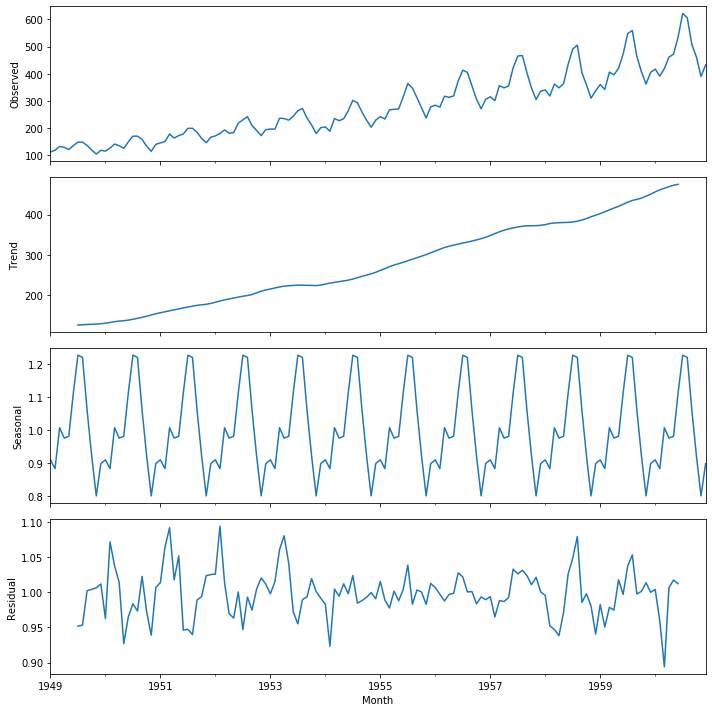

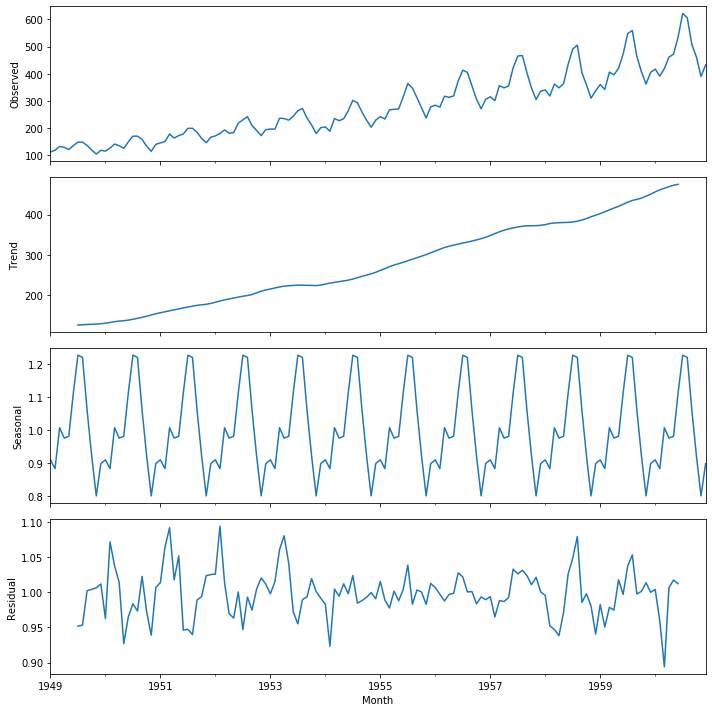

In [143]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

Using a log transformation to remove the trend (note to self, you need to learn how to test/validate that your removal of trend and seasonality actually works).

In [154]:
removed_trend = ap["#Passengers"].apply(lambda x: np.log(x))
removed_trend.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

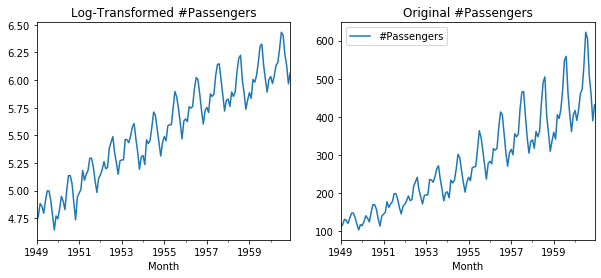

In [150]:
# compare visually
ax1 = plt.subplot(121)
removed_trend.plot(title="Log-Transformed #Passengers", figsize=(10, 4), ax=ax1)
ax2 = plt.subplot(122)
ap.plot(title="Original #Passengers", ax=ax2)

We can see that the variance has been reduced. How do we know if this is good enough? Are there some test that we can apply?

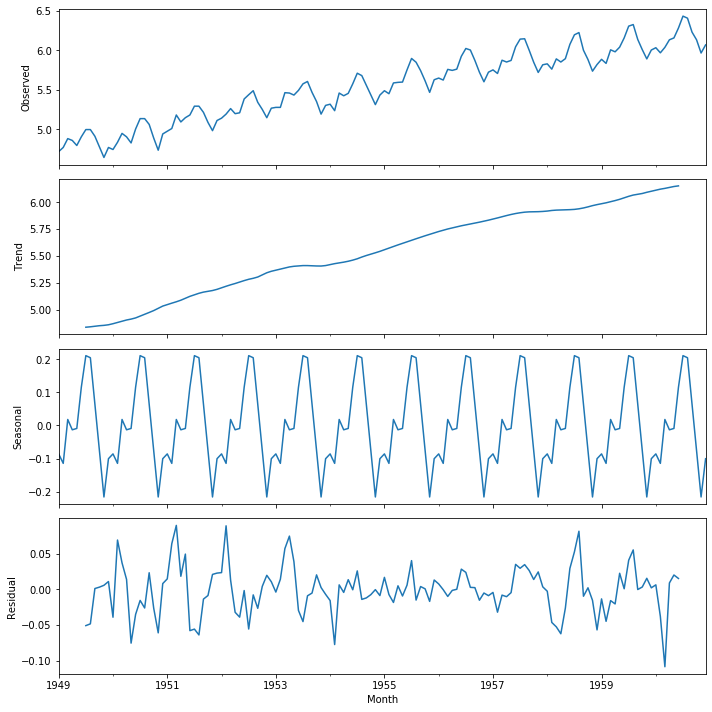

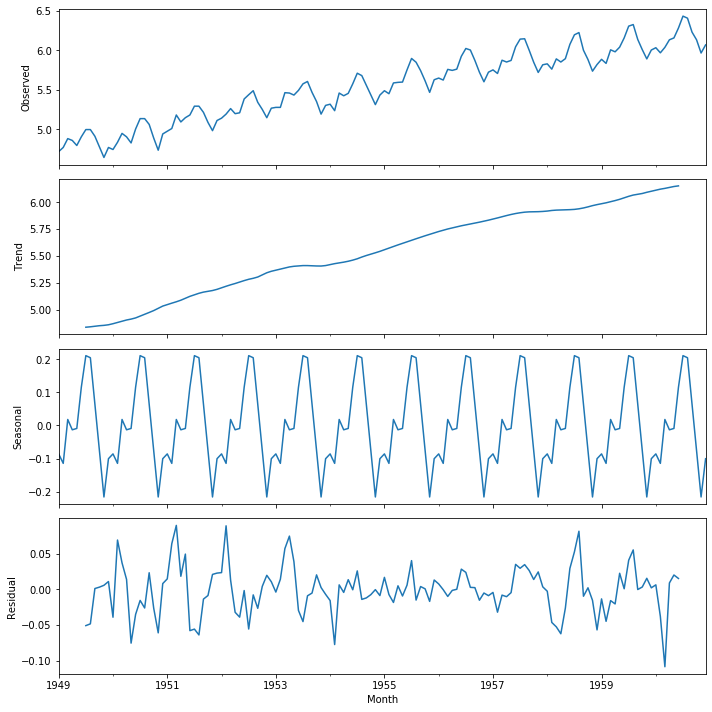

In [152]:
decomposition_after_log_transform = seasonal_decompose(removed_trend)
decomposition_after_log_transform.plot()

Next, remove seasonality using differencing the log transformed values.

In [155]:
removed_season = removed_trend - removed_trend.shift()

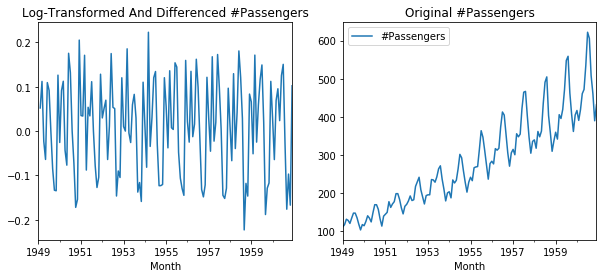

In [156]:
ax1 = plt.subplot(121)
removed_season.plot(title="Log-Transformed And Differenced #Passengers", figsize=(10, 4), ax=ax1)
ax2 = plt.subplot(122)
ap.plot(title="Original #Passengers", ax=ax2)